In [66]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px

start_date = datetime(2023, 10, 23, 0, 0, 0).replace(tzinfo=timezone.utc)
df_system = 1

DATA_DIRECTORy = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORy, "processed", "slope_intercept_acropolis.parquet"))

In [67]:
df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 1e8).alias("timestamp"))

#df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp().cast(pl.Float64)).alias("timestamp"))

In [68]:
df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{df_system}").filter(pl.col("date") > start_date)

In [69]:
fig = px.line(df_sys.collect(), x="date", y=f"slope", markers=True, title = "Slope")
fig.show()

fig = px.line(df_sys.collect(), x="date", y=f"intercept", markers=True, title = "Slope")
fig.show()

# Define slope and intercept over time with linear regression

R-squared: 0.090092


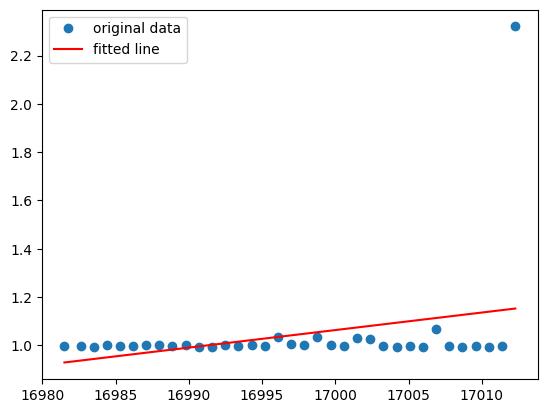

In [70]:
import numpy as np
from scipy import stats

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

x = np.array(x)
#x = range(len(y))

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

R-squared: 0.097148


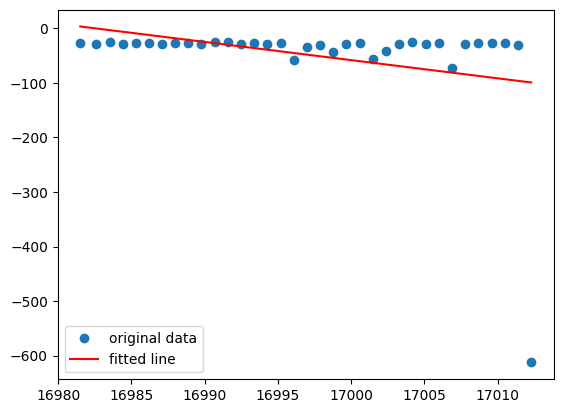

In [71]:
import numpy as np
from scipy import stats

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

x = np.array(x)
#x = range(len(y))

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

# Use RANSAC algortihm

Estimated coefficients (true, linear regression, RANSAC):
[0.00726505] [-0.00011854]


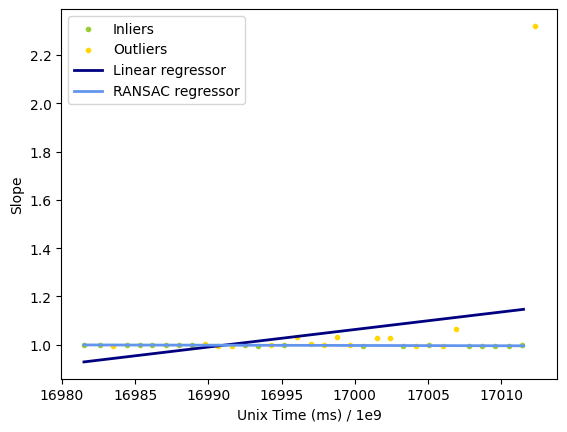

In [72]:
from sklearn import linear_model
import numpy as np

# ---- init ----

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

#x = range(len(y))

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (ms) / 1e9")
plt.ylabel("Slope")
plt.show()

Estimated coefficients (true, linear regression, RANSAC):
[-3.33766808] [0.00680222]


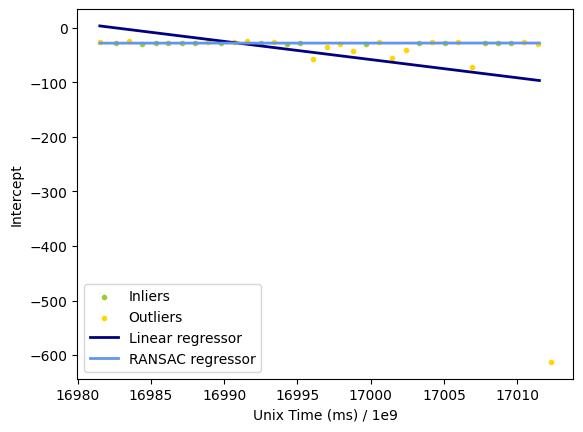

In [73]:
from sklearn import linear_model, datasets
import numpy as np

# ---- init ----

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (ms) / 1e9")
plt.ylabel("Intercept")
plt.show()